In [1]:
# # Enable remote debugging
# import debugpy
# import os

# # Only enable debugging if not already enabled
# if not debugpy.is_client_connected():
#     debugpy.listen(("localhost", 5678))
#     print("Waiting for debugger to attach...")
#     debugpy.wait_for_client()
#     print("Debugger attached!")

In [2]:
import networkx as nx
import nx_arangodb as nxadb

from arango import ArangoClient

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import re

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool


import gradio as gr
from graph_utils import create_d3_visualization
from dotenv import load_dotenv
import os
from agent_utils import GraphAgent
import pprint



[19:46:04 -0600] [INFO]: NetworkX-cuGraph is unavailable: No module named 'nx_cugraph'.


In [3]:
load_dotenv()

True

In [4]:
# Access variables
openai_key = os.getenv('OPENAI_API_KEY')
arango_host = os.getenv('ARANGO_HOST')
arango_user = os.getenv('ARANGO_USER')
arango_password = os.getenv('ARANGO_PASSWORD')
arango_db = os.getenv('ARANGO_DB')


In [5]:
# Initialize the client for ArangoDB.
client = ArangoClient(hosts=arango_host)
db = client.db(arango_db, username=arango_user, password=arango_password)
print(db.collections())

[{'id': '195137', 'name': '_aqlfunctions', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '195140', 'name': '_apps', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '211044', 'name': 'Users', 'system': False, 'type': 'document', 'status': 'loaded'}, {'id': '211046', 'name': 'plays', 'system': False, 'type': 'edge', 'status': 'loaded'}, {'id': '195141', 'name': '_appbundles', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '195135', 'name': '_graphs', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '195138', 'name': '_queues', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '195136', 'name': '_analyzers', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '195139', 'name': '_jobs', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '195142', 'name': '_frontend', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '211045', 'name': 'Games', 'system': False, 'type': 'docu

In [6]:

G_adb = nxadb.Graph(name="SteamGraph", db=db)

print(G_adb)

[19:46:08 -0600] [INFO]: Graph 'SteamGraph' exists.
[19:46:08 -0600] [INFO]: Default node type set to 'Games'


Graph named 'SteamGraph' with 14950 nodes and 70477 edges


In [7]:
graph_def = db.collection("_graphs").get("SteamGraph")
print(graph_def)


{'_key': 'SteamGraph', '_id': '_graphs/SteamGraph', '_rev': '_jSSTH52---', 'edgeDefinitions': [{'collection': 'plays', 'from': ['Users'], 'to': ['Games']}], 'orphanCollections': [], 'networkx': {'name': 'SteamGraph'}}


In [8]:
for node, data in list(G_adb.nodes(data=True))[:10]:
    print(node, data.get("_id"))


Games/11970_dino_d_day Games/11970_dino_d_day
Users/153434378 Users/153434378
Users/148073435 Users/148073435
Users/73495968 Users/73495968
Users/292976473 Users/292976473
Games/11532_mind_path_to_thalamus_enhanced_edition Games/11532_mind_path_to_thalamus_enhanced_edition
Users/230399561 Users/230399561
Users/42456478 Users/42456478
Games/12816_one_manga_day Games/12816_one_manga_day
Users/18109027 Users/18109027


In [9]:
print(G_adb)

Graph named 'SteamGraph' with 14950 nodes and 70477 edges


### AQL Test

In [10]:
# First, let's check what collections exist
print("Available collections:")
for collection in db.collections():
    print(collection['name'])

# Get the graph to see its collections
graph = db.graph('SteamGraph')
print("\nGraph collections:")
print(graph.edge_definitions())

Available collections:
_aqlfunctions
_apps
Users
plays
_appbundles
_graphs
_queues
_analyzers
_jobs
_frontend
Games

Graph collections:
[{'edge_collection': 'plays', 'from_vertex_collections': ['Users'], 'to_vertex_collections': ['Games']}]


In [11]:


# -----------------------------------------------------------
# 1. Query 3 random nodes from the Users collection.
# -----------------------------------------------------------
result_cursor = G_adb.query("""
    FOR node IN Users
        SORT RAND()
        LIMIT 3
        RETURN node
""")
print("Sample Users Nodes:")
for node in result_cursor:
    print(node)
print('-'*10)

# -----------------------------------------------------------
# 2. Query 3 random edges from the plays edge collection.
# -----------------------------------------------------------
result_cursor = G_adb.query("""
    FOR edge IN plays
        SORT RAND()
        LIMIT 3
        RETURN edge
""")
print("Sample Plays Edges:")
for edge in result_cursor:
    print(edge)
print('-'*10)


Sample Users Nodes:
{'_key': '175831055', '_id': 'Users/175831055', '_rev': '_jPaYbqe-_F', 'type': 'Users', 'steamid': 175831055}
{'_key': '248757796', '_id': 'Users/248757796', '_rev': '_jPaYbk2--X', 'type': 'Users', 'steamid': 248757796}
{'_key': '163086238', '_id': 'Users/163086238', '_rev': '_jPaYbkO--I', 'type': 'Users', 'steamid': 163086238}
----------
Sample Plays Edges:
{'_key': '24947', '_id': 'plays/24947', '_from': 'Users/237810083', '_to': 'Games/11922_brick_force', '_rev': '_jPaYgf---A', 'weight': 0.1}
{'_key': '17531', '_id': 'plays/17531', '_from': 'Users/125226713', '_to': 'Games/11623_counter_strike', '_rev': '_jPaYgKW--e', 'weight': 510}
{'_key': '804', '_id': 'plays/804', '_from': 'Users/151229648', '_to': 'Games/11874_wakfu', '_rev': '_jPaYfMa--O', 'weight': 912}
----------


### Agent

In [12]:
arango_graph = ArangoGraph(db)


In [13]:
# If the schema is exposed as an attribute
graph_schema = arango_graph.schema
pprint.pprint(graph_schema)


{'Collection Schema': [{'collection_name': 'Users',
                        'collection_type': 'document',
                        'document_properties': [{'name': '_key', 'type': 'str'},
                                                {'name': '_id', 'type': 'str'},
                                                {'name': '_rev', 'type': 'str'},
                                                {'name': 'type', 'type': 'str'},
                                                {'name': 'steamid',
                                                 'type': 'int'}],
                        'example_document': {'_id': 'Users/151603712',
                                             '_key': '151603712',
                                             '_rev': '_jPaYbhm---',
                                             'steamid': 151603712,
                                             'type': 'Users'}},
                       {'collection_name': 'plays',
                        'collection_type': 'edge

In [14]:
result_cursor =  G_adb.query("""
WITH Games, plays
FOR game IN Games 
  LET playerCount = (
    FOR play IN plays 
    FILTER play._to == game._id 
    COLLECT WITH COUNT INTO length 
    RETURN length
  )[0] 
  SORT playerCount DESC 
  LIMIT 1 
  RETURN {game, playerCount: playerCount}
""")

for item in result_cursor:
    print(item)
print('-'*10)



{'game': {'_key': '11371_dota_2', '_id': 'Games/11371_dota_2', '_rev': '_jPaYcPq--B', 'type': 'Games', 'GameName': 'Dota 2'}, 'playerCount': 4841}
----------


In [15]:
arango_graph

/home/manoj99/miniconda3/envs/Arrongo/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:502: UserWarning: <built-in function any> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


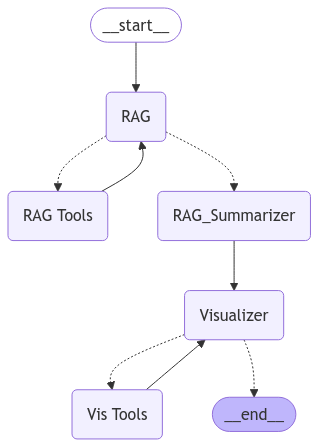

In [16]:
agent = GraphAgent(arango_graph, G_adb)


In [17]:
# def create_gradio_interface(agent):
#     def display_response(input_text):
#         result = agent.query_graph(input_text)
#         print("Inside interface")
#         print(result["html_code"])
#         return (
#             result["html_code"],
#             result["reply"]
#         )
    
#     css = """
#         #visualization-container {
#             width: 100%;
#             margin: 0;
#             padding: 0;
#         }
#         #visualization-container iframe {
#             width: 100%;
#             height: 600px;
#             border: none;
#         }
#     """
    
#     with gr.Blocks(css=css) as interface:
#         gr.Markdown("# Graph Analysis Interface")
        
#         with gr.Column():
#             input_text = gr.Textbox(
#                 label="Query",
#                 placeholder="Enter your graph query here...",
#                 lines=2
#             )
            
#             submit_btn = gr.Button("Analyze", variant="primary")
            
#             html_output = gr.HTML(
#                 label="Visualization",
#                 value="",
#                 elem_id="visualization-container"
#             )
            
#             text_output = gr.Textbox(
#                 label="Analysis Result", 
#                 lines=3
#             )
            
#         submit_btn.click(
#             fn=display_response,
#             inputs=[input_text],
#             outputs=[html_output, text_output]
#         )
    
#     return interface

In [18]:
def create_gradio_interface(agent):
    # ... (keep get_sample_data and display_response functions the same)
    def get_sample_data():
        # Get sample user IDs
        user_cursor = G_adb.query("""
        FOR user IN Users
        SORT RAND()
        LIMIT 3
        RETURN user._id
        """)
        sample_users = [user for user in user_cursor]

        # Get top games by player count
        games_cursor = G_adb.query("""
        WITH Games, plays
        FOR game IN Games
        LET playerCount = (
            FOR play IN plays 
            FILTER play._to == game._id 
            COLLECT WITH COUNT INTO length 
            RETURN length
        )[0]
        SORT playerCount DESC
        LIMIT 5
        RETURN game.GameName
        """)
        sample_games = [game for game in games_cursor]

        return sample_users, sample_games

    def display_response(input_text):
        result = agent.query_graph(input_text)
        print("Inside interface")
        print(result["html_code"])
        return (
            result["html_code"],
            result["rag_reply"]
        )
    
    # Get sample data from graph
    sample_users, sample_games = get_sample_data()
    css = """
        /* Override Gradio defaults with high specificity */
        #visualization-container, 
        #visualization-container[class],
        div#visualization-container {
            width: 100% !important;
            margin: 0 !important;
            padding: 0 !important;
            background-color: white !important;
        }
        
        #visualization-container iframe,
        #visualization-container iframe[class],
        div#visualization-container iframe {
            width: 100% !important;
            height: 600px !important;
            border: none !important;
            background-color: white !important;
        }

        /* Force white background on container and its children */
     
        .sample-panel {
            background: #f5f5f5;
            padding: 15px;
            border-radius: 8px;
            margin: 10px 0;
            border: 1px solid #ddd;
        }
        .sample-panel h3 {
            color: #000000;
            margin-bottom: 10px;
            font-weight: bold;
        }
        .sample-panel p {
            color: #000000 !important;
            margin: 5px 0;
        }
        /* Override any Gradio default text colors */
        .sample-panel * {
            color: #000000 !important;
        }
    """
    
    with gr.Blocks(css=css) as interface:
        gr.Markdown("# Graph Analysis Interface")
        
        with gr.Row():
            with gr.Column(scale=2):
                input_text = gr.Textbox(
                    label="Query",
                    placeholder="Enter your graph query here...",
                    lines=2
                )
                submit_btn = gr.Button("Analyze", variant="primary")
            
            # Sample IDs panel
            with gr.Column(scale=1):
                with gr.Column(elem_classes=["sample-panel"]):
                    # Format the sample data into markdown
                    users_md = "\n".join([f"- {user}" for user in sample_users])
                    games_md = "\n".join([f"- {game}" for game in sample_games])
                    
                    gr.Markdown(f"""
### Sample User IDs
{users_md}

### Popular Games
{games_md}
                    """)
        
        with gr.Column():
            html_output = gr.HTML(
                label="Visualization",
                value="",
                elem_id="visualization-container"
            )
            
            text_output = gr.Textbox(
                label="Analysis Result", 
                lines=3
            )
            
        submit_btn.click(
            fn=display_response,
            inputs=[input_text],
            outputs=[html_output, text_output]
        )
    
    return interface

In [19]:
# Assuming G_adb is already defined and is a NetworkX Graph object
import networkx as nx

# Calculate degree centrality for all nodes
degree_centrality = nx.degree_centrality(G_adb)

# Filter out the game nodes
game_nodes = [node for node, data in G_adb.nodes(data=True) if data.get('type') == 'Games']

# Get the game with the highest degree centrality
most_influential_game = max(game_nodes, key=lambda node: degree_centrality.get(node, 0))

# Retrieve the node data for the most influential game
FINAL_RESULT = G_adb.nodes[most_influential_game]

[19:46:17 -0600] [INFO]: Graph 'SteamGraph' load took 3.4279391765594482s


In [20]:
print(FINAL_RESULT)

{'GameName': 'Dota 2', '_id': 'Games/11371_dota_2', '_key': '11371_dota_2', 'type': 'Games'}


In [21]:
interface = create_gradio_interface(agent)
interface.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.



Processing Agent State:
[ HumanMessage(content='common users between Team Fortress 2 and  Dota 2', additional_kwargs={}, response_metadata={}, id='936221ba-b066-461a-b60d-01910bebd16c')]

==== RAG PROMPT ====
SYSTEM: You are a Graph Analysis Planner. Follow these steps:
                1. Analyze the user's query for batch processing opportunities
                2. Create optimized steps using available tools
                3. Prefer single comprehensive queries over multiple small ones
                4. Use aggregation and grouping where possible
                5. Combine results for final answer

                Rules:
                → Look for ways to handle multiple items in one tool call
                → Use summary statistics (sums, counts) in queries
                → Retrieve related data in single queries when possible
                → Handle top N results within the same query
                → Also dont bother about visulization in the plan. There is another agent fo

/mnt/mydisk/Projects/ArangoGraphRag/ArangoGraphDirectChain.py:102: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  aql_generation_chain = LLMChain(llm=llm, prompt=aql_generation_prompt)
/mnt/mydisk/Projects/ArangoGraphRag/ArangoGraphDirectChain.py:126: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  aql_generation_output = self.aql_generation_chain.run(


AQL tool query
Find the common users who have played both 'Team Fortress 2' and 'Dota 2'.


> Entering new ArangoGraphDirectChain chain...
AQL Query (1):
WITH Users, Games, plays
LET teamFortress2 = FIRST(FOR game IN Games FILTER game.GameName == 'Team Fortress 2' RETURN game._id)
LET dota2 = FIRST(FOR game IN Games FILTER game.GameName == 'Dota 2' RETURN game._id)
FOR user IN Users
    FILTER LENGTH(
        FOR play IN plays
            FILTER play._from == user._id AND (play._to == teamFortress2 OR play._to == dota2)
            COLLECT gameId = play._to WITH COUNT INTO count
            FILTER count == 2
            RETURN gameId
    ) > 0
RETURN user

AQL Result:
[]

> Finished chain.
print AQL tool result
{'query': "Find the common users who have played both 'Team Fortress 2' and 'Dota 2'. \n  Important: if returning a node always return the node object with all the properties and dont perform any llm processing on the result.I only need the direct aql result", 'result': 'Query e